## Job Clustering Final Notebook

This notebook summarizes the results of my exploration into clustering job postings based on skills and responsibilities extracted from unstructured job description text. 

In this notebook, I show final results for using TF-IDF, word embedding with word2vec and LDA to separate documents into undetermined categories.
I only briefly explore clustering methods besides kmeans because in previous notebooks, I evaluated Kmeans, Agglomerative clustering, Mean-Shift and HDBScan. Only ward agglomerative clustering came close to the results of kmeans after tuning.  

The layout of the notebook is as follows:

1. Imported dependencies
2. Data loaded from SQLite3 database
3. Defined functions that streamline my workflow, to be used in pipeline function or individually
4. Examples of function use

    a. Text preprocessing, custom stop word additions and tokenization
    
    b. TF-IDF vectorization for kmeans and ward clustering -> analyze cluster outputs through 2-D t-SNE plots and top vectors separated by cluster
    
    c. Word2Vec implementation for kmeans -> analyze cluster outputs through 2-D t-SNE plots and top vectors separated by cluster
    
    d. LDA implementation -> visualized with pyLDAvis in 2-D PCoA dimensionality, analyze topic formulas
    
    e. Elbow method implementation to justify kmean cluster number for TF-IDF, w2v and topic number for LDA
    
    f. Test potentially good topic numbers for LDA to determine interpretability of high coherence values
    
    g. LDA mallet implementation


In [38]:
#finalize notebook
#create pipeline for data processing
#Final Text Processing, changeable with input
# TF-IDF, KMean, Ward, top vectors
# Word2Vec, Kmean, Ward, top vectors
# LDA, 
#import
import re
import random
import sys
import numpy as np
import sqlite3
from operator import itemgetter
import hdbscan
from pprint import pprint
import pandas as pd #df
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from scipy.cluster.hierarchy import dendrogram
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS #vectorizers & stop_words
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, AffinityPropagation #
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import nltk
from nltk import text
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim #w2v, lda
from gensim.models import word2vec
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from wordcloud import WordCloud

In [3]:
#import data and review content
conn = sqlite3.connect(r'C:\Users\Gary_Guo\Documents\GitHub\autoapply\JobDBa.db')
cur = conn.cursor()
#25000 job descriptions at this time
cur.execute('SELECT * FROM [Jobs Indeed]')
data = cur.fetchall()
dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
print(dfa.describe())
dfa.isna().sum()

             Job Title                    Company      Location  \
count            25412                      25412         25412   
unique           16912                       8681          1349   
top     Data Scientist  Amazon.com Services, Inc.  New York, NY   
freq               529                        513          1018   

                                              Description  
count                                               25412  
unique                                              25412  
top     Duties\nSummary\nThis position is located in t...  
freq                                                    1  


Job Title      0
Company        0
Location       0
Description    0
dtype: int64

After checking over data, we confirm there are no repeat job descriptions that may affect clustering. There are no missing values. 

I initially wanted to work with a set of 50,000 job descriptions, but my computation time became too intensive so I subset the data to around 4000. I chose to use stemmer to reduce computation time.

In [9]:
dfs = dfa.sample(frac=.15, random_state=15) #subset data we will be working with
dfs['Subset_Index'] = range(len(dfs['Company'].values)) #set reference key within subset 
stemmer = SnowballStemmer('english')

In [44]:
#function that takes list of documents and determines stop_words to add based on conditions
#text variable must be dataframe
def text_process(texts, clean=True, pos=True, sentence=True, **kwargs):
    corpus = texts.Description.values #init corpus, unmodified description
    #remove repeating sentences
    if sentence is True:
        tv = CountVectorizer(tokenizer=sent_tokenize)
        tmat =tv.fit_transform(texts)
        tf = tv.get_feature_names()
        tmata = tmat.toarray()
        tmatat = tmata.transpose()
        tl = []
        for item,name in zip(tmatat, tf):
            tl.append([name, item.mean()])
        newl = []
        for item in tl:
            if item[1] >= ((1/len(texts.Description.values))*1.1):
                newl.append(item)
        nono = []
        for item in newl:
            reg = re.search('[ ]', item[0])
            if reg is None:
                nono.append(item)
        nnl = [n for n in newl if n not in nono]
        ccorpus = []
        for desc in texts.Description.values:
            sent = sent_tokenize(desc)
            nxt = [u for u in sent if u not in nnl]
            string = ''.join(nxt)
            ccorpus.append(string)
        corpus= ccorpus
    else:
        print('sentence=false')
    #clean \n and misaligned words
    if clean is True:
        ccorpus = []
        for txt in corpus:
            nre = re.sub(r"(\n)", r" ", txt) #remove "\n" characters
            cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            ccorpus.append(cap)
        corpus = ccorpus
    else:
        print('clean=false')
    #remove adjectives, adverbs, prepositions etc., unnecessary POS tagging
    if pos is True:
        ccorpus = []
        for txt in corpus:
            tokenize = nltk.wordpunct_tokenize(txt)
            pos_tag = nltk.pos_tag(tokenize)
            remove = ['PRP$','WP$','WP','WRB','WDT','UH','TO','RP','RBS','RBR','RB','PRP','MD','LS','JJS','JJ','JJR','FW','IN','DT','CC']
            out = []
            for tok in pos_tag:
                if tok[1] in remove:
                    pass
                else:
                    out.append(tok[0])
            string = ' '.join(out)
            ccorpus.append(string)
        corpus=ccorpus
    return corpus

def set_stop(corpus, df, add=True, punc=True, loc=True, num=True, company=True, max_df=0.8, min_df=.02, *args, **kwargs):
    #set stop_words
    stop_words = ENGLISH_STOP_WORDS
    stopw = nltk.corpus.stopwords.words('english') #add additional stop words
    stop_words = stop_words.union(stopw) #add punc removal
    #add stop_words unable to be filtered out from other means
    if add is True:
        add_stop=['lab','laboratory','company','inc','technology','computer','institute','public','\r','connect','people','fb','g','ge',
                  'accomadate','sexuality','sex','orientation','orient','gender','race','ethnicity','ethnic','equal','opportunity','minor',
                  'disable','veteran','female','male','employer','employee','network','require','affirm','jp','jpmorgan','chase','usa','america','canada',
                  'career','job','compani', 'work','location','origin','religion','ident','sexual','color','identity','nation','national',
                 'disability','protect','protected','background','screening','screen','drug','diversity','diverse','employment',
                 'employ','affirimative','action','applicant','discrimination','discriminate','apply','application', 'resume','agency','agent',
                 '\r \r', 'proud','inclusive','inclusion','recruit','recruitment','recruiter','hire','submit','agree','agreement',
                 'marital', 'status', 'marriage', 'help','require','perform','duty','duti','provide','accomod', 'authorization','author',
                 'type','time','salary', '00','000 00', '000', 'citizenship','citizen','large','identify','crime','criminal', 
                 'ancestry', "you're","you'r","we're","we'r", 'minority','abuse', 'affirm', 'united', 'states', 'province', 'shift',
                 '’','skill','ability', 'skills','role', 'assist','prepare','office','email','com','hr','contact','require','requir',
                 'benefit','insure','health','vision','dental','plan', 'pay','paid','staff','401','RSP','k','consider','consid','candid','safety','safeti',
                 'u','hour','perform','act','policy','polici', 'compensation','compensate','match','matching','insurance','insur', 'claim'
                 'texas','texa','state','tuition','traffic','million','billion','lunch','coffee','include','use','inform','age','agree','agreement',
                 'law','regard','applic','www','driver','401k','express','vet','veterans','disabilities','eeo','pto','leave','paternity','mat','maternity'
                 'world','join','value','build'] #removal of stop-words that were unable to be filtered out from other methods
        stop_words = stop_words.union(add_stop)
    else:
        print('add=false')
    #remove punc not captured by regex
    if punc is True:
        punct = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'",'-','>','<','/','^', ''] 
        stop_words = stop_words.union(punct)
    else:
        print('punc=false')
    #remove numbers 1 through 10 from stopword removal - keep years experience desired
    if num is True:
        high = range(11,4400,1)
        sw = []
        for item in high:
            sw.append(str(item))
        stop_words = stop_words.union(sw)
    else:
        print('num=false')
    
    #remove company names
    if company is True:
        comp = df.Company.values
        pcom = []
        for item in comp:
            pcom.append(item.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #location removal
    if loc is True:
        location = df.Location.values
        pcom = []
        for item in location:
            w = wordpunct_tokenize(item)
            for itr in w:
                pcom.append(itr.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #add stop_words based on document frequency cutoffs
    cv = CountVectorizer(max_df = max_df, min_df = min_df, stop_words=stop_words, tokenizer=wordpunct_tokenize)
    cvm = cv.fit(corpus)
    swp = cv.stop_words_
    stop_words = stop_words.union(swp)
    #remove recurring sentences
    return stop_words

#call after processing
def gg_tokenize(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    stem = [stemmer.stem(word) for word in h]   #stem words after stop_word removal and tokenization
    return stem

def gg_tokenize_stem(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    stem = [stemmer.stem(word) for word in h]   #stem words after stop_word removal and tokenization
    h = [n for n in stem if not n in stem_stop] #remove stop_words after stemming
    return h

def cloud_tokenize(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    return h

In [6]:
#Feature generation with TF-IDF
def tfidf_get(corpus, stop_words, tokenizer, max_df=.8, min_df=.02, **kwargs):
    tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, tokenizer=tokenizer)
    tmatrix = tfidf.fit_transform(corpus)
    ftn = tfidf.get_feature_names()
    return tfidf, tmatrix, ftn

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector


def averaged_word_vectorizer(token, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in token]
    return np.array(features)

#Feature engineer through word embedding
def w2v_get(token, feature_size=50, window_context=12,min_word_count=2,sample=1e-3, itr=40,**kwargs):
    w2v_model = word2vec.Word2Vec(token, size=feature_size, window=window_context, min_count = min_word_count, sample=sample, iter=itr)
    w2v_feature_array = averaged_word_vectorizer(token=token, model=w2v_model, num_features=feature_size)
    return w2v_feature_array
    

#Feature Engineer with LDA, Topic Modeling
def lda_get(corpus, num_topics=20, random_state=100, update_every=1, 
           chunksize=100,passes=20, alpha='auto',per_word_topics=True, **kwargs):
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=tdf,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=random_state,
                                               update_every=update_every,
                                               chunksize=chunksize,
                                               passes=passes,
                                               alpha=alpha,
                                               per_word_topics=per_word_topics)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, tdf, id2word)
    vtsne = pyLDAvis.gensim.prepare(lda_model, tdf, id2word, mds='tsne')
    
    label_df = pd.DataFrame()

    # Get main topic in each document
    for row in lda_model[tdf]:
        row = sorted(row[0], key=itemgetter(1), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = lda_model.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        label_df = label_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(corpus)
    label_df = pd.concat([label_df, contents], axis=1)
    label_df.columns = ['Cluster Label', 'Perc_Contribution', 'Topic_Keywords', 'Tokenized Text']
    
    top_doc = pd.DataFrame()
    grouped = label_df.groupby('Cluster Label')

    for i, grp in grouped:
        top_doc = pd.concat([top_doc, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
    return lda_model, label_df, top_doc, vis, vtsne

def lda_mallet_get(corpus, num_topics=20, **kwargs):
    mallet_path = r'C:/Users/Gary_Guo/Documents/mallet-2.0.8/bin/mallet' # update this path
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tdf, num_topics=num_topics, id2word=id2word)
    label_df = pd.DataFrame()
    # Get main topic in each document
    for row in lda_model[tdf]:
        row = sorted(row, key=itemgetter(1), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = lda_model.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        label_df = label_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(corpus)
    label_df = pd.concat([label_df, contents], axis=1)
    label_df.columns = ['Cluster Label', 'Perc_Contribution', 'Topic_Keywords', 'Tokenized Text']
    
    top_doc = pd.DataFrame()
    grouped = label_df.groupby('Cluster Label')

    for i, grp in grouped:
        top_doc = pd.concat([top_doc, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
    return lda_model, label_df, top_doc

#Feature Engineer with LDA, Topic Modeling
def lda_opt(corpus, rnge, random_state=100, update_every=1, 
           chunksize=100,passes=20, alpha='auto',per_word_topics=True, **kwargs):
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    perp_list = []
    coh_list = []
    for i in rnge:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=tdf,
                                                   id2word=id2word,
                                                   num_topics=i, 
                                                   random_state=random_state,
                                                   update_every=update_every,
                                                   chunksize=chunksize,
                                                   passes=passes,
                                                   alpha=alpha,
                                                   per_word_topics=per_word_topics)
        perplexity = lda_model.log_perplexity(tdf)
        coherence = CoherenceModel(model=lda_model, texts= corpus, dictionary = id2word, coherence='c_v')
        coherence_lda = coherence.get_coherence()
        perp_list.append(perplexity)
        coh_list.append(coherence_lda)
    return perp_list, coh_list

def lda_mallet_opt(corpus, rnge, **kwargs):
    mallet_path = r'C:/Users/Gary_Guo/Documents/mallet-2.0.8/bin/mallet' # update this path
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    coh_list = []
    for i in rnge:
        lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tdf, num_topics=num_topics, id2word=id2word)
        coherence = CoherenceModel(model=lda_model, texts= corpus, dictionary = id2word, coherence='c_v')
        coherence_lda = coherence.get_coherence()
        coh_list.append(coherence_lda)
    return coh_list

In [11]:
#kmean clustering
def kmeans(matrix, n_clusters=10, **kwargs):
    km = KMeans(n_clusters=n_clusters)
    km.fit(matrix)
    dfk = dfs.copy()
    dfk['Cluster Label'] =km.labels_
    return km, dfk
#Ward linkage agglomerative clustering
def ward(matrix, n_clusters=10, **kwargs):
    agc = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward',affinity='euclidean')
    agc.fit_predict(matrix.todense())
    dfw = dfs.copy()
    dfw['Cluster Label'] =agc.labels_
    return agc, dfw
#elbow method test optimal k
def elbow(matrix, rnge):
    ssd = []
    sil = []
    sil_samp = []
    for n in rnge:
        km = KMeans(n_clusters=n)
        km.fit(matrix)
        ssd.append(km.inertia_)
        sil_avg = silhouette_score(matrix, km.labels_)
        samp_sil = silhouette_samples(matrix, km.labels_)
        sil.append(sil_avg)
        sil_samp.append(samp_sil)
    return ssd, sil, sil_samp
#graph clusters in 2-D space, choose dimensionality reduction technique    
def graph_cluster(matrix, df, dim='t-SNE', **kwargs):
    dist = 1-cosine_similarity(matrix)
    dfg = df.copy()
    cond = 0
    if dim=='t-SNE':
        tsne = TSNE(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='PCA':
        tsne = PCA(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='MDS':
        tsne = MDS(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    else:
        'Dimensionality reduction tool not available. Please choose "t-SNE","PCA", or "MDS"'
        cond=1
    if cond ==1:
        pass
    else:
        plt.figure(figsize=(16,12))
        sns.scatterplot(x='Dim-1', y='Dim-2', data=dfg, hue='Cluster Label', legend='full', palette='nipy_spectral_r')
        plt.show()
    return dfg
#determine top TF-IDF vectors in each cluster
def centroid_vector(model, ftn, top=20, **kwargs):
    order_centroid = model.cluster_centers_.argsort()[:, ::-1] 
    cent_top = {}
    for i in range(len(order_centroid)):
        values= []
        for ind in order_centroid[i, :top]: #replace 6 with n words per cluster
            values.append(ftn[ind])
        cent_top[i] = values
    return cent_top
# Top count vectorizer in each cl  
def conv_top(corpus, df, stop_words, max_df=.8, min_df=.02, top=30, **kwargs):
    cluster_top_vectors = {}
    cv = CountVectorizer(max_df=.8, min_df=.02, stop_words=stop_words,tokenizer = wordpunct_tokenize)
    cvm = cv.fit_transform(corpus)
    for i in range(0,len(df['Cluster Label'].unique())):
        dfc = df.loc[df['Cluster Label'] ==i]
        lab = df.index.tolist()
        crn = cvm.toarray()
        labelem = []
        for item, l in zip(crn, lab):
            labelem.append([l,item])
        l1 = [n for n in labelem if n[0] in dfc.index]
        newm = []
        for item in l1:
            newm.append(item[1])
        newmt = np.array(newm).transpose()
        topv = []
        for item,name in zip(newmt,cv.get_feature_names()):
            mn = item.mean()
            topv.append([name,mn])
        topvs = sorted(topv, key=itemgetter(1), reverse=True)
        topn = []
        for item in topvs[0:top]:
            topn.append(item[0])
        cluster_top_vectors[i]=topn
    return cluster_top_vectors
    


In [12]:
#process text for TF-IDF, w2v and LDA
corpus = text_process(dfs)
stop_words = set_stop(corpus, dfs)
stem_stop = [stemmer.stem(word) for word in stop_words]
#different tokenizers 
wpt = nltk.WordPunctTokenizer()
wpt_corpus =[wpt.tokenize(document) for document in corpus]
gg_corpus = [gg_tokenize(document) for document in corpus]
ggt_corpus = [gg_tokenize_stem(document) for document in corpus]

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [')/', '+', '.)', '10', '10x', '2dream', '2nd', '5', '6', '7', '7ac', '9th', 'a123', 'a2z', 'aaa', 'abbott', 'abbvie', 'abc', 'absolute', 'academia', 'academies', 'academy', 'acadian', 'accelerated', 'access', 'accolade', 'accudyne', 'ace', 'actors', 'acumen', 'ad', 'adaptive', 'adara', 'adb', 'addiction', 'adept', 'admin', 'administration', 'administrators', 'advanced', 'advent', 'adventures', 'advisor', 'advisors', 'advisory', 'aegis', 'aera', 'aeroinfo', 'aerospace', 'aesir', 'aether', 'ag', 'agap', 'agar', 'agelix', 'aggreko', 'agilent', 'agilon', 'ai', 'aids', 'airbus', 'airlines', 'airport', 'aj', 'akraya', 'akshaya', 'akvelon', 'alchemy', 'algonquin', 'allen', 'alliance', 'alliant', 'allpro', 'alom', 'alpha', 'alphaserve', 'alpine', 'alt', 'altman', 'altus', 'amazing', 'amazon', 'american', 'ame

In [13]:
#tfidf kmean
tfidf, tmatrix, ftn = tfidf_get(corpus, stem_stop, gg_tokenize)
km, dfk = kmeans(tmatrix)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0', '00000043', '000001', '000004', '00002', '000072', '00022h', '00079p', '001120', '0030098', '003251', '00489p', '0057', '00735', '009526', '012159', '01218p', '01376', '013954', '01486', '015077', '01782', '01987270', '042619', '0519', '0558p', '057', '058', '0630', '0912', '0firmwar', '0g', '0job', '0s7lc8ddmpbw2n0x6l2b9nmjw7t5xzs2zgcjzw8rbgyz3r2nnxf3m', '0x1', '0y8ksi8', '1', '10', '1001six', '10288br', '10k', '110a', '1116182b11', '11801', '13428', '13665', '1370330', '13752br', '1415406210925', '14635br', '14944br', '16z', '1706sinc', '178b', '19000101', '19297', '19313', '19593', '1ajjpm0u', '1desir', '1job', '1k', '1q', '1requir', '1servic', '1the', '1vwtvpva0', '1x1', '2', '2050r', '211mn', '26993ebf7fb8f', '2a', '2desir', '2dream', '2ee', '2f2c', '2fprovid', '2hsr', '2j', '2open', '2p', '

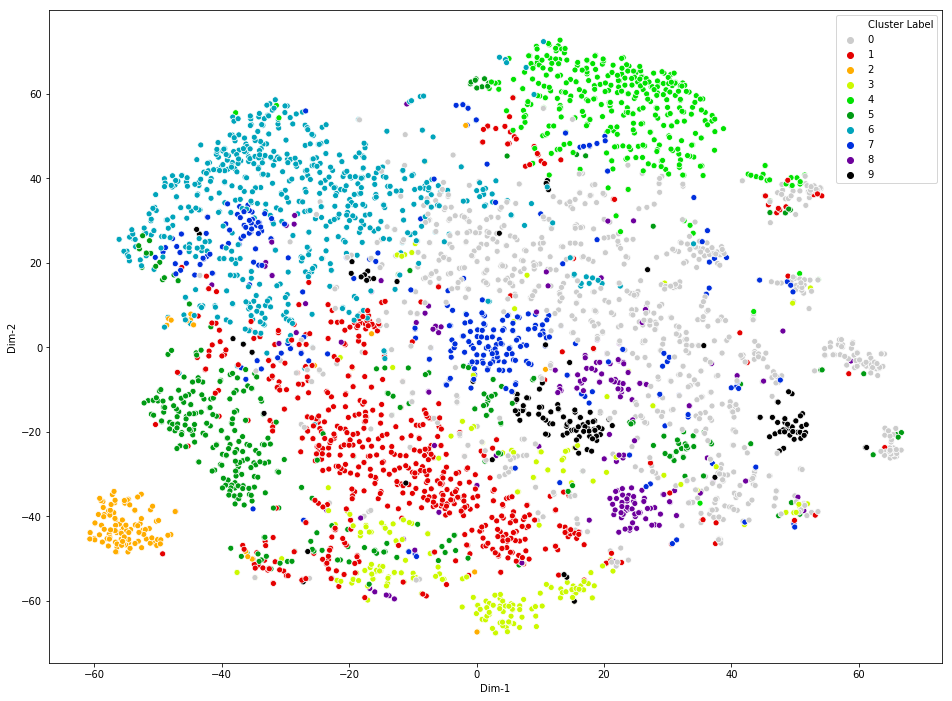

In [14]:
dfkt = graph_cluster(tmatrix, dfk)

In [15]:
centroid_vec = centroid_vector(km, ftn)
top_count_vec = conv_top(corpus, dfk, stop_words)
for x,y in zip(centroid_vec.items(), top_count_vec.items()):
    print(x[0])
    print(x[1])
    print(y[1])
    print()
dfkt['Top Vectors'] = dfkt['Cluster Label'].map(centroid_vec)
dfkt.to_csv('tfkm.csv')

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '10', '2dream', '5', '6', '7', '7ac', '9th', 'a123', 'a2z', 'access', 'accolade', 'acumen', 'ad', 'administration', 'advanced', 'aegis', 'aeroinfo', 'agelix', 'ai', 'aj', 'akshaya', 'allpro', 'amazon', 'ameritech', 'amzn', 'analytical', 'analytics', 'anthony', 'apar', 'app', 'applications', 'applied', 'architects', 'arlo', 'aspects', 'asset', 'assets', 'associates', 'assurance', 'atgtech', 'athletica', 'auditoria', 'auto', 'automation', 'ava', 'avenza', 'b', 'bank', 'banking', 'bath', 'bbs', 'benefits', 'bentex', 'best', 'bevstrat', 'big', 'biology', 'boar', 'board', 'boccard', 'bock', 'bont', 'brandfwd', 'brands', 'bridgewater', 'brightside', 'brookfield', 'budget', 'building', 'burst', 'business', 'c', 'california', 'campaign', 'cancer', 'capital', 'caprus', 'care', 'careers', 'carlisle',

0
['ensur', 'busi', 'make', 'lead', 'meet', 'qualif', 'problem', 'risk', 'day', 'offer', 'drive', '–', 'communiti', 'member', 'strategi', 'asset', 'goal', 'written', 'student', '5']
['management', 'support', 'business', 'including', 'engineering', 'required', 'development', 'customer', 'information', 'years', 'knowledge', 'systems', 'working', 'design', 'environment', 'product', 'position', 'project', 'process', 'quality', 'requirements', 'world', 'projects', 'develop', 'ensure', 'customers', 'products', 'teams', 'communication', 'research']

1
['java', 'languag', 'python', 'busi', 'framework', 'web', 'sql', 'scienc', 'api', 'problem', 'hadoop', 'c', 'javascript', 'make', 'big', '3', 'deliv', 'scala', 'lead', 'linux']
['software', 'development', 'design', 'learning', 'systems', 'working', 'business', 'knowledge', 'years', 'engineering', 'tools', 'technologies', 'machine', 'using', 'environment', 'building', 'world', 'product', 'applications', 'python', 'cloud', 'including', 'testing', 

From these vector outputs, we can determine the clusters are structured very well according to skills and responsibiltiies. The centroid vectors are very coherent and interpretable.

Cluster 0 - Business - Project Management - Traditional Engineering

Cluster 1 - Software Development - Cloud computing - Web development - Data Engineering

Cluster 2 - Amazon Cloud Services - Software Development - Data Engineering

Cluster 3 - Software Engineering + Traditional Engineering

Cluster 4 - Business Analyst - Sales focus 

Cluster 5 - Data Scientist

Cluster 6 - Data Analyst + Business Analyst

Cluster 7 - Data Analyst + Financial Analyst

Cluster 8 - Clustered based on defined years of experience, big mix

Cluster 9 - Healthcare Industry - Traditional Scientist, Research Analyst 

Many clusters are relatively well defined but quite mixed. Cluster 8 is weakest. Cluster 5 is strongest.

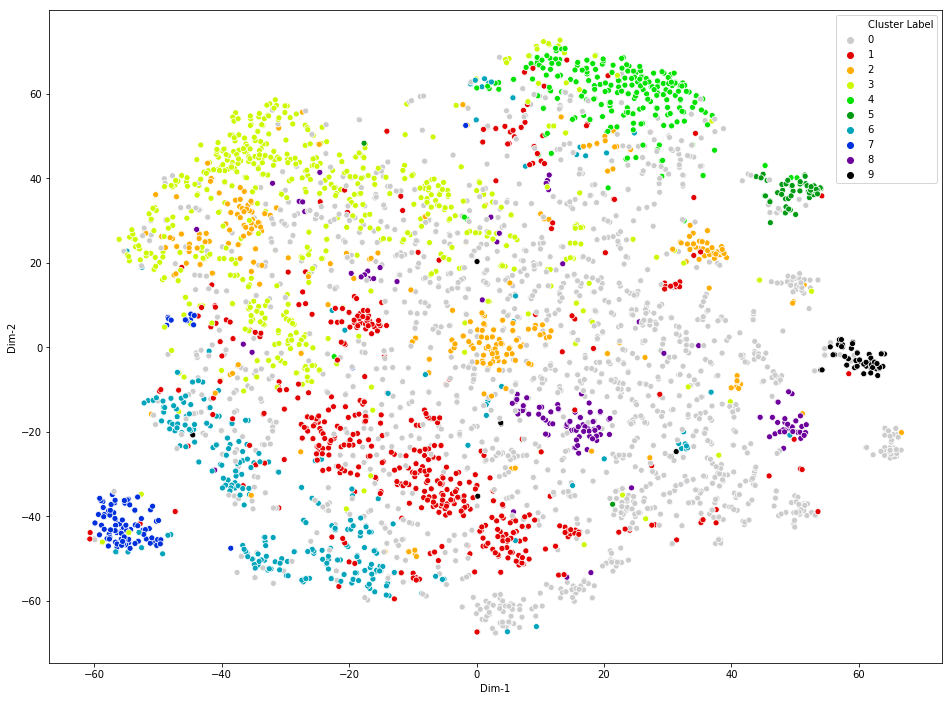

In [16]:
agc, dfw = ward(tmatrix)
dfwt = graph_cluster(tmatrix, dfw)

In [17]:
top_count_vec = conv_top(corpus, dfw, stop_words)
for x in top_count_vec.items():
    print(x[0])
    print(x[1])
    print()
dfwt['Top Vectors'] = dfwt['Cluster Label'].map(top_count_vec)
dfwt.to_csv('tfw.csv')

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '10', '2dream', '5', '6', '7', '7ac', '9th', 'a123', 'a2z', 'access', 'accolade', 'acumen', 'ad', 'administration', 'advanced', 'aegis', 'aeroinfo', 'agelix', 'ai', 'aj', 'akshaya', 'allpro', 'amazon', 'ameritech', 'amzn', 'analytical', 'analytics', 'anthony', 'apar', 'app', 'applications', 'applied', 'architects', 'arlo', 'aspects', 'asset', 'assets', 'associates', 'assurance', 'atgtech', 'athletica', 'auditoria', 'auto', 'automation', 'ava', 'avenza', 'b', 'bank', 'banking', 'bath', 'bbs', 'benefits', 'bentex', 'best', 'bevstrat', 'big', 'biology', 'boar', 'board', 'boccard', 'bock', 'bont', 'brandfwd', 'brands', 'bridgewater', 'brightside', 'brookfield', 'budget', 'building', 'burst', 'business', 'c', 'california', 'campaign', 'cancer', 'capital', 'caprus', 'care', 'careers', 'carlisle',

0
['business', 'management', 'engineering', 'support', 'years', 'development', 'systems', 'required', 'design', 'including', 'knowledge', 'software', 'working', 'product', 'information', 'environment', 'customer', 'research', 'position', 'requirements', 'project', 'analysis', 'process', 'learning', 'quality', 'projects', 'products', 'world', 'degree', 'develop']

1
['development', 'software', 'business', 'design', 'working', 'knowledge', 'systems', 'tools', 'years', 'technologies', 'test', 'learning', 'engineering', 'environment', 'using', 'management', 'world', 'support', 'testing', 'including', 'building', 'product', 'cloud', 'teams', 'applications', 'machine', 'science', 'infrastructure', 'requirements', 'develop']

2
['analysis', 'business', 'management', 'support', 'including', 'knowledge', 'risk', 'information', 'required', 'reporting', 'years', 'development', 'research', 'reports', 'working', 'degree', 'requirements', 'projects', 'tools', 'environment', 'position', 'analytics', 

Cluster 0 - Traditional Engineering + Software Engineering + Business Management

Cluster 1 -  Software Engineering + Data Engineering

Cluster 2 - Business Intelligence, Financial Analyst

Cluster 3 - Data Analyst 

Cluster 4 - Data Analyst - Business focus

Cluster 5 - Marketing and Sales Analytics

Cluster 6 - Data Science - Machine Learning Engineer - Software Engineer

Cluster 8 - Healthcare jobs - Data science, research analyst, traditional scientist

Cluster 9 - Mixed, wrong key words

Still somewhat interpretable, but cluster 0 is overwhelming and encompasses many of the jobs. Cluster 9 is uninterpretable. 


In [18]:
#get w2vwpt
wpt2v_array = w2v_get(wpt_corpus)
kmwp2, dfkwp2 = kmeans(wpt2v_array)
# agwp2, dfagwp2 = ward(wpt2v_array)

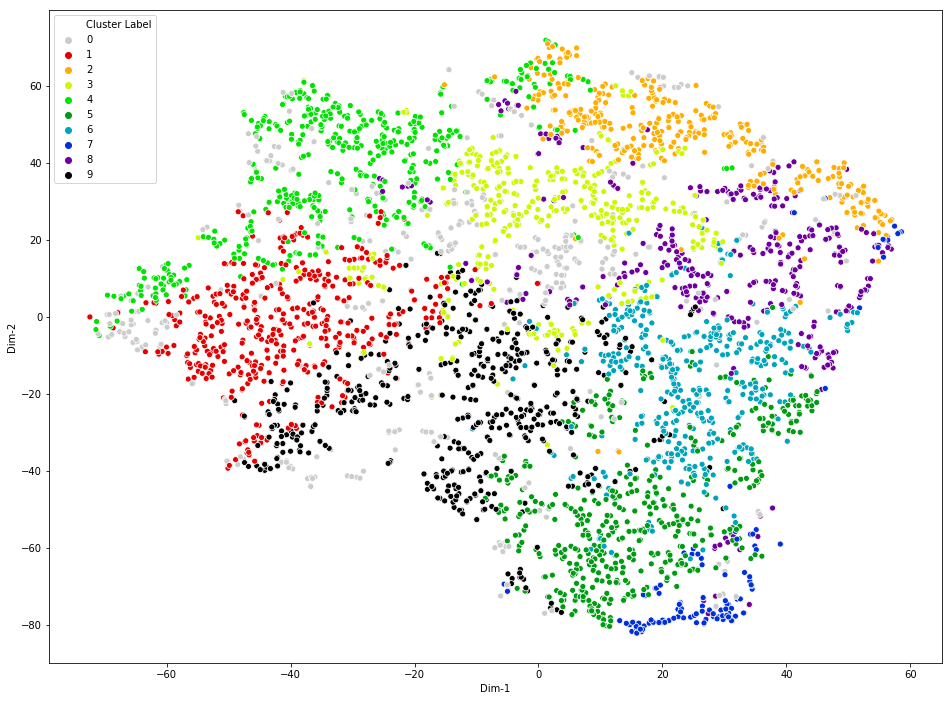

In [19]:
dfwp = graph_cluster(wpt2v_array, dfkwp2)

In t-SNE 2-D space, w2v seems to create more defined clusters. There are visually more separated clusters.

In [20]:
wpt_top = conv_top(corpus, dfkwp2, stop_words)
for key, value in wpt_top.items():
    print(key)
    print(value)
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '10', '2dream', '5', '6', '7', '7ac', '9th', 'a123', 'a2z', 'access', 'accolade', 'acumen', 'ad', 'administration', 'advanced', 'aegis', 'aeroinfo', 'agelix', 'ai', 'aj', 'akshaya', 'allpro', 'amazon', 'ameritech', 'amzn', 'analytical', 'analytics', 'anthony', 'apar', 'app', 'applications', 'applied', 'architects', 'arlo', 'aspects', 'asset', 'assets', 'associates', 'assurance', 'atgtech', 'athletica', 'auditoria', 'auto', 'automation', 'ava', 'avenza', 'b', 'bank', 'banking', 'bath', 'bbs', 'benefits', 'bentex', 'best', 'bevstrat', 'big', 'biology', 'boar', 'board', 'boccard', 'bock', 'bont', 'brandfwd', 'brands', 'bridgewater', 'brightside', 'brookfield', 'budget', 'building', 'burst', 'business', 'c', 'california', 'campaign', 'cancer', 'capital', 'caprus', 'care', 'careers', 'carlisle',

0
['development', 'software', 'business', 'systems', 'learning', 'design', 'engineering', 'years', 'working', 'research', 'science', 'including', 'information', 'knowledge', 'world', 'machine', 'support', 'required', 'environment', 'tools', 'analysis', 'qualifications', 'management', 'applicants', 'requirements', 'position', 'technologies', 'analytics', 'develop', 'using']

1
['business', 'product', 'world', 'customer', 'working', 'make', 'teams', 'development', 'support', 'marketing', 'management', 'environment', 'analytics', 'customers', 'learning', 'products', 'years', 'looking', 'sales', 'design', 'develop', 'including', 'building', 'growth', 'engineering', 'clients', 'software', 'tools', 'opportunities', 'analysis']

2
['learning', 'machine', 'business', 'science', 'development', 'years', 'knowledge', 'design', 'software', 'working', 'tools', 'engineering', 'analytics', 'systems', 'using', 'aws', 'analysis', 'technologies', 'python', 'models', 'cloud', 'sql', 'develop', 'building'

Too many clusters business related, unable to find data engineering, skip to custom tokenizer.

In [21]:
#get w2vgg
gg_array = w2v_get(gg_corpus)
kmgg, dfkgg = kmeans(gg_array)

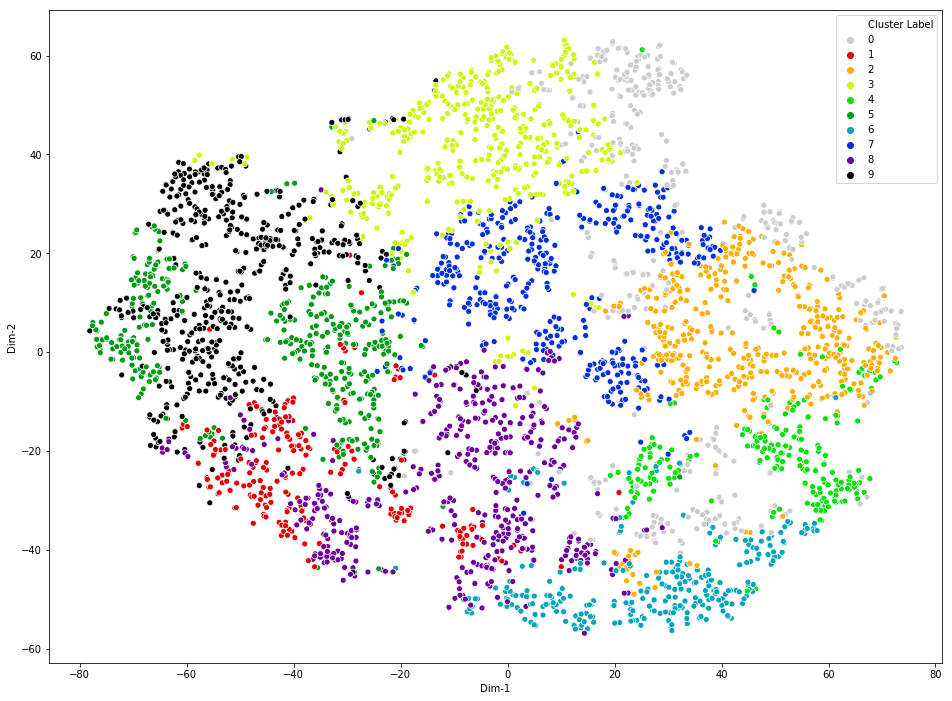

In [22]:
dfw2g = graph_cluster(gg_array, dfkgg)

In [23]:
gg_top = conv_top(corpus, dfkgg, stop_words)
for key, value in gg_top.items():
    print(key)
    print(value)
    print()

dfw2g['Top Vectors'] = dfw2g['Cluster Label'].map(gg_top)
dfw2g.to_csv('w2vggk.csv')

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '10', '2dream', '5', '6', '7', '7ac', '9th', 'a123', 'a2z', 'access', 'accolade', 'acumen', 'ad', 'administration', 'advanced', 'aegis', 'aeroinfo', 'agelix', 'ai', 'aj', 'akshaya', 'allpro', 'amazon', 'ameritech', 'amzn', 'analytical', 'analytics', 'anthony', 'apar', 'app', 'applications', 'applied', 'architects', 'arlo', 'aspects', 'asset', 'assets', 'associates', 'assurance', 'atgtech', 'athletica', 'auditoria', 'auto', 'automation', 'ava', 'avenza', 'b', 'bank', 'banking', 'bath', 'bbs', 'benefits', 'bentex', 'best', 'bevstrat', 'big', 'biology', 'boar', 'board', 'boccard', 'bock', 'bont', 'brandfwd', 'brands', 'bridgewater', 'brightside', 'brookfield', 'budget', 'building', 'burst', 'business', 'c', 'california', 'campaign', 'cancer', 'capital', 'caprus', 'care', 'careers', 'carlisle',

0
['business', 'management', 'support', 'including', 'required', 'environment', 'customer', 'information', 'years', 'working', 'project', 'development', 'position', 'knowledge', 'projects', 'benefits', 'process', 'employees', 'world', 'systems', 'clients', 'communication', 'customers', 'responsibilities', 'requirements', 'client', 'research', 'quality', 'operations', 'degree']

1
['years', 'development', 'business', 'software', 'design', 'knowledge', 'aws', 'tools', 'sql', 'technologies', 'systems', 'working', 'using', 'preferred', 'cloud', 'engineering', 'science', 'python', 'analytics', '+', 'big', 'required', 'architecture', 'including', 'management', 'java', 'learning', 'applications', '5', 'spark']

2
['business', 'management', 'support', 'requirements', 'project', 'analysis', 'information', 'required', 'including', 'systems', 'knowledge', 'process', 'reports', 'processes', 'years', 'projects', 'reporting', 'development', 'analyst', 'position', 'ensure', 'quality', 'issues', 'work

Cluster 0 - Mix of finance, business management and data analyst 

Cluster 1 - Data engineer, Big data

Cluster 2 - Mix of analysts, Business, Finance, Research, 

Cluster 3 - Big mix of jobs - business analytics related

Cluster 4 - Traditional Scientist - Research Analysts

Cluster 5 - Machine Learning Engineer - Data Scientists

Cluster 6 - Traditional Engineering

Cluster 7 - Data Analyst - reporting, visualization

Cluster 8 - Software Development, Data Engineering

Cluster 9 - Software Engineering, Data Engineering, Cloud, Big Data

w2v model performs pretty well. In my opinion, it performs better than the TF-IDF models because it separates the business analysts all into one group. Traditional engineering is much better defined from software engineering. Data science and machine learning is well defined. 

In [24]:
lad,label_df, group_df, vis,vtsne = lda_get(gg_corpus)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [25]:
lad.print_topics()

[(0,
  '0.041*"requir" + 0.027*"manag" + 0.020*"maintain" + 0.018*"document" + 0.017*"support" + 0.017*"knowledg" + 0.017*"report" + 0.015*"perform" + 0.015*"project" + 0.015*"duti"'),
 (1,
  '0.291*"custom" + 0.159*"product" + 0.123*"sale" + 0.033*"market" + 0.025*"support" + 0.024*"account" + 0.017*"success" + 0.014*"busi" + 0.012*"relationship" + 0.012*"crm"'),
 (2,
  '0.140*"engin" + 0.064*"design" + 0.043*"construct" + 0.029*"project" + 0.027*"develop" + 0.026*"manufactur" + 0.026*"equip" + 0.025*"product" + 0.025*"process" + 0.024*"system"'),
 (3,
  '0.115*"learn" + 0.095*"machin" + 0.029*"engin" + 0.027*"algorithm" + 0.024*"develop" + 0.023*"model" + 0.022*"ai" + 0.022*"scienc" + 0.020*"c" + 0.017*"problem"'),
 (4,
  '0.064*"manag" + 0.057*"busi" + 0.049*"develop" + 0.039*"project" + 0.025*"process" + 0.020*"ensur" + 0.020*"support" + 0.019*"lead" + 0.016*"partner" + 0.016*"leadership"'),
 (5,
  '0.054*"busi" + 0.052*"report" + 0.043*"analysi" + 0.034*"analyst" + 0.018*"requir" 

Topic 0 - Manage projects, business, supply chain

Topic 1 - Sales and marketing

Topic 2 - Traditional engineering

Topic 3 - Machine learning

Topic 4 - Business management

Topic 5 - Data analyst - business focus, reporting visualization

Topic 6 - Marketing

Topic 7 - General software

Topic 8 - Data science

Topic 9 - General company benefits - bad topic

Topic 10 - Testing, QA, product design - Traditional engineering

Topic 11 - Consulting

Topic 12 - General buzz words - bad topic

Topic 13 - Data engineering

Topic 14 - Better data engineering topic - aws cloud platform focus

Topic 15 - Science research, healthcare

Topic 16 - Banking and finance

Topic 17 - Numerical year qualifications - bad topic

Topic 18 - General company benefits - bad topic

Topic 19 - Software engineering, web development

There are 5-6 bad topics. The other topics are relatively well defined. The problem is Cluster 12 has 1020 postings, 1/4 of the entire dataset. That is a big flaw in the topic - it is too general and encompasses too many postings. 

In [26]:
print(label_df['Cluster Label'].value_counts())

12.0    1020
0.0      632
5.0      415
4.0      385
3.0      220
2.0      148
11.0     112
14.0     107
19.0     103
15.0      97
13.0      92
7.0       90
8.0       68
6.0       65
16.0      64
9.0       63
10.0      49
17.0      37
18.0      28
1.0       17
Name: Cluster Label, dtype: int64


In [27]:
label_df.head(10)

Cluster Label  Perc_Contribution  \
0            0.0             0.5180   
1            2.0             0.4004   
2           12.0             0.4659   
3           12.0             0.4896   
4           14.0             0.2137   
5           15.0             0.2927   
6           12.0             0.3478   
7            3.0             0.1784   
8            7.0             0.3215   
9           12.0             0.4353   

                                      Topic_Keywords  \
0  requir, manag, maintain, document, support, kn...   
1  engin, design, construct, project, develop, ma...   
2  product, make, world, work, creat, look, learn...   
3  product, make, world, work, creat, look, learn...   
4  aw, engin, databas, amazon, pipelin, hadoop, s...   
5  research, develop, analysi, scienc, studi, sci...   
6  product, make, world, work, creat, look, learn...   
7  learn, machin, engin, algorithm, develop, mode...   
8  secur, system, support, infrastructur, oper, m...   
9  product, make, world, work, creat, look, learn...   

                                      Tokenized Text  
0  [univers, locat, heart, california, world, lea...  
1  [world, class, engin, team, oper, collabor, st...  
2  [way, compani, spend, manag, softwar, help, bu...  
3  [assist, make, differ, enjoy, worker, leader, ...  
4  [bachelor, degre, scienc, econom, math, statis...  
5  [mission, power, communiti, bring, world, fami...  
6  [look, autom, engin, shape, organ, cultur, eff...  
7  [associ, scientist, make, enterpris, analyt, s...  
8  [lead, cloud, base, server, manag, strive, dev...  
9  [softwar, engin, machin, learn, research, dedi...

In [28]:
df_merge = pd.merge(dfs, label_df, left_on='Subset_Index', right_index=True, how='inner')
df_merge.head(20)

Job Title  \
20706                    Human Resources Administrator 1   
6195                                  Interiors Engineer   
1892                 Business Development Representative   
15137                           Administrative Assistant   
14128  Business Intelligence Engineer - Merchant Rank...   
21406  Data Scientist - Survey Methodology and Comput...   
17480                                Automation Engineer   
12116                           Associate Data Scientist   
10719                    Information Technology Engineer   
17447                                    Product Manager   
188    Junior Data and Cloud Engineer (18 Month Contr...   
11436                                      Data Engineer   
4103                             Customer Senior Analyst   
5337                              Data Science, Director   
2293                              Senior devops Engineer   
23815                                    Account Manager   
956    Senior Software Development Engineer – In-Memo...   
22659  Technical Solutions Engineer, Chrome and Andro...   
2583                             Infrastructure Engineer   
19532             Analyst, Marketing Strategy & Research   

                              Company                 Location  \
20706             Stanford University             Stanford, CA   
6195                            Byton          Santa Clara, CA   
1892                        Procurify            Vancouver, BC   
15137         ABC Legal Services Inc.        Seattle, WA 98104   
14128       Amazon.com Services, Inc.              Seattle, WA   
21406                        Facebook        Seattle, WA 98101   
17480                        Freenome        San Francisco, CA   
12116            Valley National Bank          Wayne, NJ 07470   
10719                          LogDNA  Mountain View, CA 94041   
17447                         Twitter  San Francisco, CA 94103   
188               BMO Financial Group              Toronto, ON   
11436                           Apple         Austin, TX 78758   
4103               The Clorox Company         Boston, MA 02108   
5337                    Fitch Ratings        Chicago, IL 60602   
2293                       Virgiltech          Mississauga, ON   
23815            Container Management         Austin, TX 78744   
956    AMZN CAN Fulfillment Svcs, ULC            Vancouver, BC   
22659                          Google       New York, NY 10011   
2583                      SS&C Advent              Toronto, ON   
19532                      Conde Nast       New York, NY 10048   

                                             Description  Subset_Index  \
20706  Stanford University, located between San Franc...             0   
6195   Our world-class engineering teams operate with...             1   
1892   Who we are\nAt Procurify, our team is reinvent...             2   
15137  Administrative Assistant\n\nMake a difference....             3   
14128  Bachelor’s Degree in a technical or analytical...             4   
21406  Facebook's mission is to give people the power...             5   
17480  About the Role\n\nFreenome is looking for an A...             6   
12116  The Associate, Data Scientist plays a critical...             7   
10719  LogDNA, a leading intuitive cloud services-bas...             8   
17447  Who We Are:\n\nWe are a team of software engin...             9   
188    The primary role of the Junior Data and Cloud ...            10   
11436  Summary\nPosted: Oct 31, 2018\nWeekly Hours: 4...            11   
4103   Supports customer team by gathering, analyzing...            12   
5337   Fitch Group is a global leader in financial in...            13   
2293   Overview\n\nOur client in GTA area is currentl...            14   
23815  Our South Austin based company is looking to a...            15   
956    Bachelor’s Degree in Computer Science or relat...            16   
22659  Note: By applying to this position your applic...           

In [29]:
pyLDAvis.save_html(vis, 'lda.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.047357  0.168330       1        1  15.685418
0      0.136087 -0.098304       2        1  12.674490
4      0.095590  0.074843       3        1  12.082490
5     -0.016619 -0.024226       4        1   8.670788
11     0.231174 -0.011100       5        1   5.929062
18     0.137071 -0.207717       6        1   4.274384
13    -0.140116  0.013504       7        1   3.913512
3     -0.196438  0.001248       8        1   3.846378
19    -0.271463 -0.012984       9        1   3.532518
2     -0.118296 -0.077049      10        1   3.449837
9      0.190554 -0.185050      11        1   3.407600
6      0.104391  0.187880      12        1   3.088891
8     -0.129940 -0.033423      13        1   3.024807
15    -0.023517 -0.120071      14        1   2.966414
7     -0.090082  0.021864      15        1   2.773492
14    -0.219885  0.054245      16        1   2.754506
17     0.086375 -0.179961      17        1   2.222226
10    -0.070648 -0.004920      18        1   2.150375
1      0.152712  0.254951      19        1   1.898745
16     0.095694  0.177938      20        1   1.654063, topic_info=    Category          Freq       Term         Total  loglift  logprob
41   Default   5916.000000     custom   5916.000000  30.0000  30.0000
236  Default   8108.000000    product   8108.000000  29.0000  29.0000
208  Default   7863.000000      engin   7863.000000  28.0000  28.0000
136  Default   4081.000000   research   4081.000000  27.0000  27.0000
248  Default   3953.000000       test   3953.000000  26.0000  26.0000
177  Default   6316.000000       year   6316.000000  25.0000  25.0000
48   Default  11834.000000    develop  11834.000000  24.0000  24.0000
93   Default   5039.000000      learn   5039.000000  23.0000  23.0000
99   Default  10441.000000      manag  10441.000000  22.0000  22.0000
101  Default   3808.000000     market   3808.000000  21.0000  21.0000
24   Default   3954.000000     client   3954.000000  20.0000  20.0000
19   Default  10063.000000       busi  10063.000000  19.0000  19.0000
243  Default   4665.000000    softwar   4665.000000  18.0000  18.0000
203  Default   6116.000000     design   6116.000000  17.0000  17.0000
134  Default   9186.000000     requir   9186.000000  16.0000  16.0000
392  Default   2675.000000     machin   2675.000000  15.0000  15.0000
133  Default   4840.000000     report   4840.000000  14.0000  14.0000
182  Default   4490.000000    analysi   4490.000000  13.0000  13.0000
157  Default   6275.000000    support   6275.000000  12.0000  12.0000
124  Default   6072.000000    project   6072.000000  11.0000  11.0000
405  Default   2821.000000    qualiti   2821.000000  10.0000  10.0000
224  Default   3187.000000      model   3187.000000   9.0000   9.0000
299  Default   1795.000000       sale   1795.000000   8.0000   8.0000
420  Default   2888.000000     analyt   2888.000000   7.0000   7.0000
158  Default   4314.000000     system   4314.000000   6.0000   6.0000
121  Default   6238.000000    process   6238.000000   5.0000   5.0000
144  Default   3410.000000     scienc   3410.000000   4.0000   4.0000
0    Default   1696.000000          1   1696.000000   3.0000   3.0000
123  Default   3896.000000    program   3896.000000   2.0000   2.0000
449  Default   2488.000000     prefer   2488.000000   1.0000   1.0000
..       ...           ...        ...           ...      ...      ...
871  Topic20     45.528126       keep    179.476624   2.7302  -5.5594
336  Topic20    175.593094       firm    717.422485   2.6944  -4.2096
852  Topic20     46.366230          9    193.108261   2.6753  -5.5412
360  Topic20     70.171700     thrive    375.719055   2.4240  -5.1268
735  Topic20     35.296532      divis    195.585968   2.3897  -5.8140
612  Topic20    109.758339     consum    690.720642   2.2625  -4.6795
38   Topic20    157.171600    control    998.508179   2.2530  -4.3204
13   Topic20     17.713272      award  

In [30]:
vtsne #note crossover between documents with specific topics, 

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
12     36.309875   7.400970       1        1  15.685521
0       1.141779 -33.128147       2        1  12.674479
4     -45.757912  50.618088       3        1  12.082108
5     -26.747551  33.074142       4        1   8.670547
11     11.500672  11.036258       5        1   5.929194
18    -24.507635 -42.990135       6        1   4.274647
13    -24.837332 -18.580429       7        1   3.913449
3     -51.878742 -30.933634       8        1   3.846680
19    -10.344700  15.975436       9        1   3.531927
2      -1.865447  36.266426      10        1   3.449642
9      -4.280571  -7.392964      11        1   3.407629
6     -45.143536  18.879295      12        1   3.088966
8      21.042017 -15.941948      13        1   3.024901
15      9.196097  58.562786      14        1   2.966591
7     -66.082451  31.891943      15        1   2.774028
14    -19.547071  58.581585      16        1   2.754307
17    -47.779819  -6.709422      17        1   2.222107
10    -27.551361   4.275318      18        1   2.150435
1      24.853889  34.060871      19        1   1.898793
16    -70.373756   2.725972      20        1   1.654054, topic_info=    Category          Freq       Term         Total  loglift  logprob
41   Default   5916.000000     custom   5916.000000  30.0000  30.0000
236  Default   8108.000000    product   8108.000000  29.0000  29.0000
208  Default   7863.000000      engin   7863.000000  28.0000  28.0000
136  Default   4081.000000   research   4081.000000  27.0000  27.0000
248  Default   3953.000000       test   3953.000000  26.0000  26.0000
177  Default   6316.000000       year   6316.000000  25.0000  25.0000
48   Default  11833.000000    develop  11833.000000  24.0000  24.0000
93   Default   5039.000000      learn   5039.000000  23.0000  23.0000
99   Default  10441.000000      manag  10441.000000  22.0000  22.0000
101  Default   3808.000000     market   3808.000000  21.0000  21.0000
24   Default   3954.000000     client   3954.000000  20.0000  20.0000
19   Default  10063.000000       busi  10063.000000  19.0000  19.0000
243  Default   4664.000000    softwar   4664.000000  18.0000  18.0000
203  Default   6116.000000     design   6116.000000  17.0000  17.0000
134  Default   9186.000000     requir   9186.000000  16.0000  16.0000
392  Default   2676.000000     machin   2676.000000  15.0000  15.0000
133  Default   4840.000000     report   4840.000000  14.0000  14.0000
182  Default   4490.000000    analysi   4490.000000  13.0000  13.0000
157  Default   6275.000000    support   6275.000000  12.0000  12.0000
124  Default   6072.000000    project   6072.000000  11.0000  11.0000
405  Default   2821.000000    qualiti   2821.000000  10.0000  10.0000
224  Default   3188.000000      model   3188.000000   9.0000   9.0000
299  Default   1795.000000       sale   1795.000000   8.0000   8.0000
420  Default   2888.000000     analyt   2888.000000   7.0000   7.0000
158  Default   4314.000000     system   4314.000000   6.0000   6.0000
121  Default   6238.000000    process   6238.000000   5.0000   5.0000
144  Default   3410.000000     scienc   3410.000000   4.0000   4.0000
0    Default   1696.000000          1   1696.000000   3.0000   3.0000
123  Default   3896.000000    program   3896.000000   2.0000   2.0000
449  Default   2488.000000     prefer   2488.000000   1.0000   1.0000
..       ...           ...        ...           ...      ...      ...
871  Topic20     45.527882       keep    179.476791   2.7302  -5.5594
336  Topic20    175.592148       firm    717.433350   2.6944  -4.2096
852  Topic20     46.365982          9    193.112564   2.6752  -5.5412
360  Topic20     70.171326     thrive    375.720551   2.4240  -5.1268
735  Topic20     35.296341      divis    195.589417   2.3897  -5.8140
612  Topic20    109.757751     consum    690.728027   2.2625  -4.6795
38   Topic20    157.170761    control    998.478516   2.2530  -4.

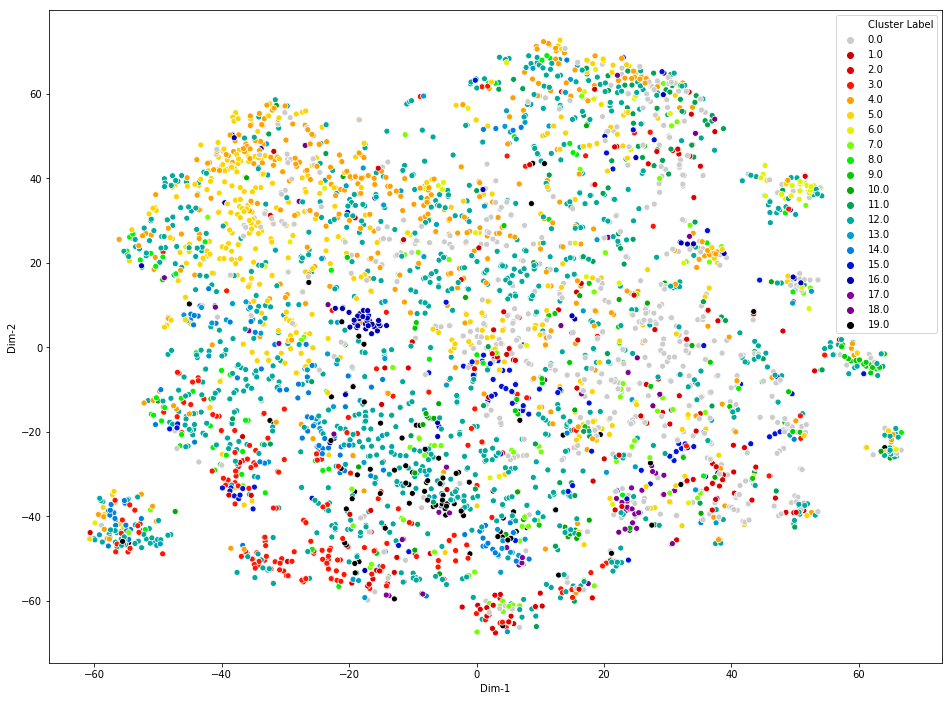

In [31]:
dfldt = graph_cluster(tmatrix, df_merge)
dfldt.to_csv('ldat20.csv')

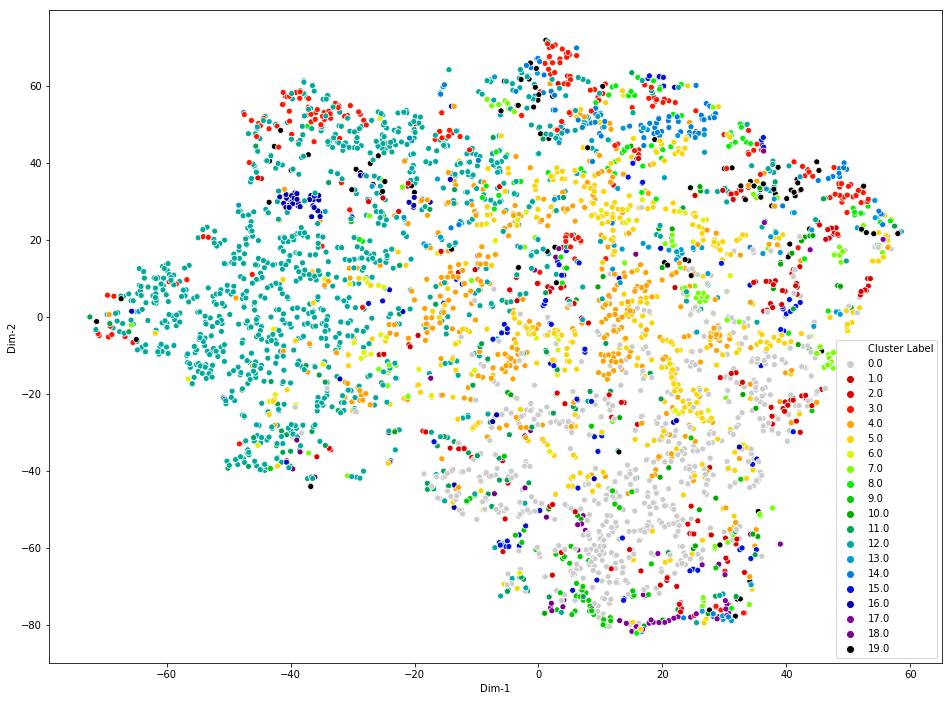

In [32]:
dfldw = graph_cluster(wpt2v_array, df_merge)
dfldw.to_csv('ldaw20.csv')

In [44]:
ss, sil, sil_samp = elbow(tmatrix, range(5,30,1))

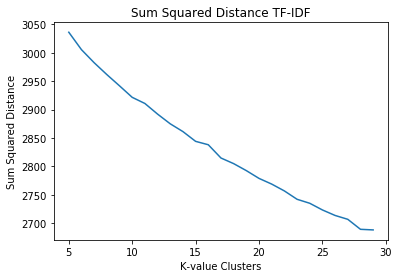

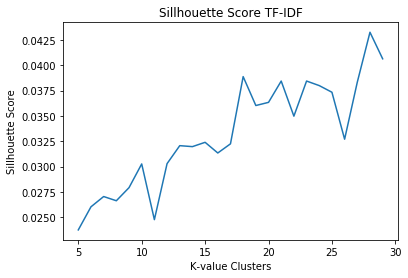

In [71]:
#5 - 30, 
plt.plot(range(5,30,1),ss)
plt.title('Sum Squared Distance TF-IDF')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),sil)
plt.title('Sillhouette Score TF-IDF')
plt.ylabel('Sillhouette Score')
plt.xlabel('K-value Clusters')
plt.show()

# optimal at 10, 18 -> try 18

In [54]:
ss10, sil10, sil_samp10 = elbow(tmatrix, range(10,100,5))

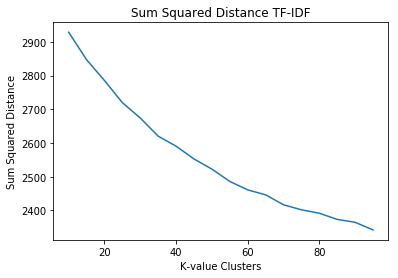

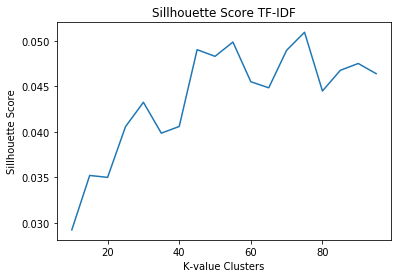

In [72]:
#10 -100, observe longer term trend
plt.plot(range(10,100,5),ss10)
plt.title('Sum Squared Distance TF-IDF')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(10,100,5),sil10)
plt.title('Sillhouette Score TF-IDF')
plt.ylabel('Sillhouette Score')
plt.xlabel('K-value Clusters')
plt.show()
#continuous improvement, may not be interpretable at such high number of clusters

In [58]:
sswp, silwp, sil_sampwp = elbow(wpt2v_array, range(5,30,1))
ssgg, silgg, sil_sampgg = elbow(gg_array, range(5,30,1))


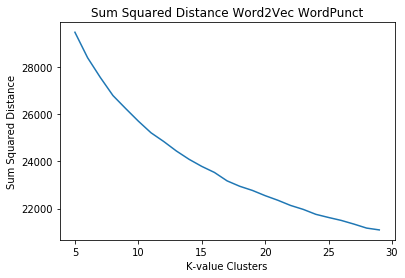

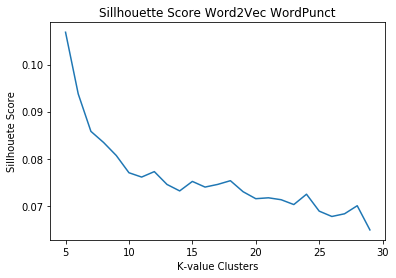

In [74]:
plt.plot(range(5,30,1),sswp)
plt.title('Sum Squared Distance Word2Vec WordPunct')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),silwp)
plt.title('Sillhouette Score Word2Vec WordPunct')
plt.ylabel('Sillhouete Score')
plt.xlabel('K-value Clusters')
plt.show()
#optimal around 10 and 17

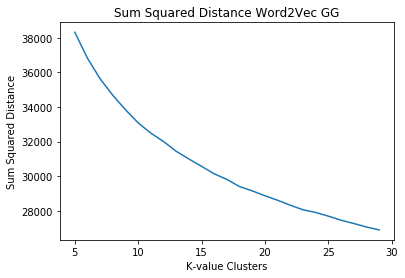

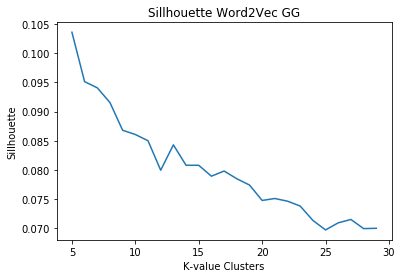

In [75]:
plt.plot(range(5,30,1),ssgg)
plt.title('Sum Squared Distance Word2Vec GG')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),silgg)
plt.title('Sillhouette Word2Vec GG')
plt.ylabel('Sillhouette')
plt.xlabel('K-value Clusters')
plt.show()
#13 and 17

In [78]:
perp_list, coh_list = lda_opt(gg_corpus, range(10,50,5))   

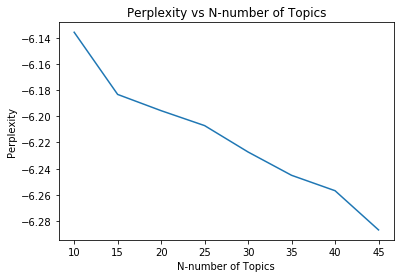

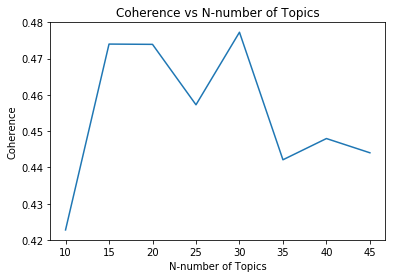

In [79]:
plt.plot(range(10,50,5),perp_list)
plt.title('Perplexity vs N-number of Topics')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(10,50,5),coh_list)
plt.title('Coherence vs N-number of Topics')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

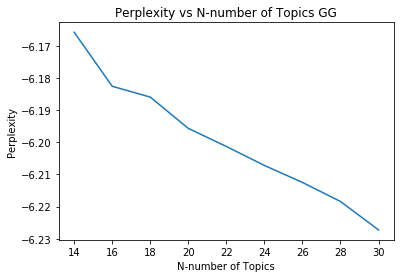

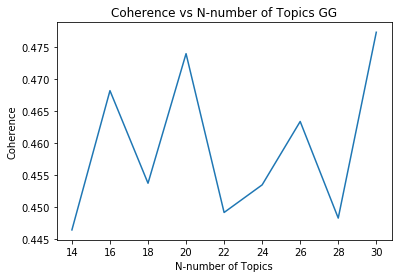

In [77]:
perp_list, coh_list = lda_opt(gg_corpus, range(14,32,2))   
plt.plot(range(14,32,2),perp_list)
plt.title('Perplexity vs N-number of Topics GG')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(14,32,2),coh_list)
plt.title('Coherence vs N-number of Topics GG')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()
# 20 good number of topics, peak coherence and kink in perplexity

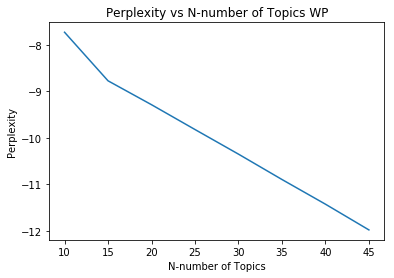

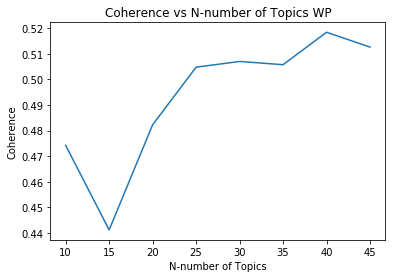

In [80]:
perp_listwp, coh_listwp = lda_opt(wpt_corpus, range(10,50,5))   
plt.plot(range(10,50,5),perp_listwp)
plt.title('Perplexity vs N-number of Topics WP')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(10,50,5),coh_listwp)
plt.title('Coherence vs N-number of Topics WP')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

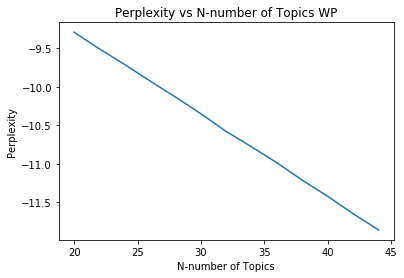

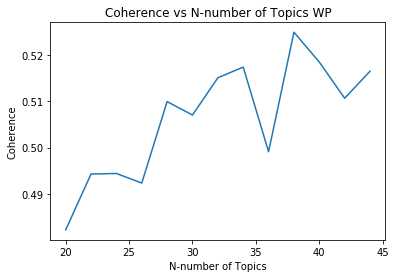

In [81]:
perp_listwpl, coh_listwpl = lda_opt(wpt_corpus, range(20,45,2))   
plt.plot(range(20,45,2),perp_listwpl)
plt.title('Perplexity vs N-number of Topics WP')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(20,45,2),coh_listwpl)
plt.title('Coherence vs N-number of Topics WP')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

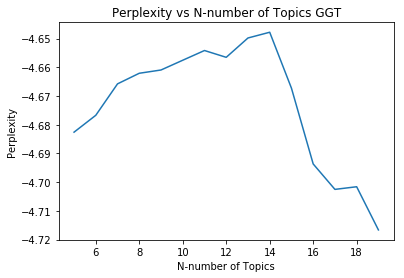

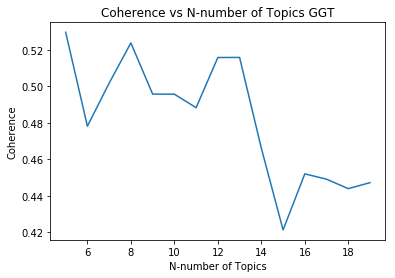

In [235]:
perp_listwpl, coh_listwpl = lda_opt(ggt_corpus, range(5,20,1))   
plt.plot(range(5,20,1),perp_listwpl)
plt.title('Perplexity vs N-number of Topics GGT')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(5,20,1),coh_listwpl)
plt.title('Coherence vs N-number of Topics GGT')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

In [33]:
ladm, label_mdf, topm_doc = lda_mallet_get(gg_corpus, num_topics=20)

In [34]:
dfmallet_merge = pd.merge(dfs, label_mdf, left_on='Subset_Index', right_index=True, how='inner')
dfmallet_merge.head(5)

Job Title  \
20706                    Human Resources Administrator 1   
6195                                  Interiors Engineer   
1892                 Business Development Representative   
15137                           Administrative Assistant   
14128  Business Intelligence Engineer - Merchant Rank...   

                         Company           Location  \
20706        Stanford University       Stanford, CA   
6195                       Byton    Santa Clara, CA   
1892                   Procurify      Vancouver, BC   
15137    ABC Legal Services Inc.  Seattle, WA 98104   
14128  Amazon.com Services, Inc.        Seattle, WA   

                                             Description  Subset_Index  \
20706  Stanford University, located between San Franc...             0   
6195   Our world-class engineering teams operate with...             1   
1892   Who we are\nAt Procurify, our team is reinvent...             2   
15137  Administrative Assistant\n\nMake a difference....             3   
14128  Bachelor’s Degree in a technical or analytical...             4   

       Cluster Label  Perc_Contribution  \
20706           15.0             0.2996   
6195             2.0             0.2076   
1892            18.0             0.2219   
15137           18.0             0.2036   
14128           10.0             0.1809   

                                          Topic_Keywords  \
20706  requir, posit, program, inform, duti, educ, de...   
6195   engin, requir, design, oper, equip, control, s...   
1892   make, grow, day, benefit, world, passion, buil...   
15137  make, grow, day, benefit, world, passion, buil...   
14128  busi, analyt, tool, analysi, insight, model, s...   

                                          Tokenized Text  
20706  [univers, locat, heart, california, world, lea...  
6195   [world, class, engin, team, oper, collabor, st...  
1892   [way, compani, spend, manag, softwar, help, bu...  
15137  [assist, make, differ, enjoy, worker, leader, ...  
14128  [bachelor, degre, scienc, econom, math, statis...

In [35]:
ladm.print_topics()

[(0,
  '0.221*"product" + 0.198*"custom" + 0.031*"team" + 0.023*"deliv" + 0.021*"understand" + 0.021*"drive" + 0.018*"user" + 0.016*"success" + 0.016*"problem" + 0.015*"lead"'),
 (1,
  '0.102*"report" + 0.054*"manag" + 0.047*"analyst" + 0.040*"account" + 0.040*"analysi" + 0.039*"support" + 0.025*"financ" + 0.024*"excel" + 0.023*"perform" + 0.021*"analyz"'),
 (2,
  '0.129*"engin" + 0.044*"requir" + 0.039*"design" + 0.030*"oper" + 0.029*"equip" + 0.024*"control" + 0.020*"system" + 0.020*"perform" + 0.019*"manufactur" + 0.019*"posit"'),
 (3,
  '0.123*"learn" + 0.078*"machin" + 0.063*"model" + 0.059*"scienc" + 0.029*"engin" + 0.028*"scientist" + 0.026*"problem" + 0.025*"languag" + 0.023*"python" + 0.020*"algorithm"'),
 (4,
  '0.136*"process" + 0.072*"qualiti" + 0.055*"improv" + 0.045*"ensur" + 0.036*"requir" + 0.031*"document" + 0.027*"chang" + 0.027*"issu" + 0.022*"standard" + 0.020*"plan"'),
 (5,
  '0.115*"test" + 0.106*"develop" + 0.095*"softwar" + 0.076*"design" + 0.034*"code" + 0.026*

LDA mallet implementation seems to perform quite well. The topics seem slightly more interpretable. 

Topic 0 - Data analyst - Business Analyst, reporting

Topic 1 - Finance, reporting analytics

Topic 2 - Traditional engineering - process, QA, design

Topic 3 - Machine learning

Topic 4 - Supply chain, process improvement

Topic 5 - Software development, web

Topic 6 - Big data, cloud, data engineering

Topic 7 - General application information - bad topic

Topic 8 - General application information - bad topic

Topic 9 - Consulting

Topic 10 - Data analyst - modeling, visualization

Topic 11 - Business analyst, financial, misc analysts

Topic 12 - Marketing, sales, strategy 

Topic 13 - Senior technical leads - engineering and data science

Topic 14 - Software engineering, IT

Topic 15 - general words - bad topic

Topic 16 - Degree requirements, experience years -> bad topic

Topic 17 - Research, healthcare, traditional science

Topic 18 - general buzz word - bad topic

Topic 19 - Communication, excel work, office management

LDA mallet performs better overall because it has better distribution of topics. There are still several bad topics, but they have a smaller impact on clustering job postings. 


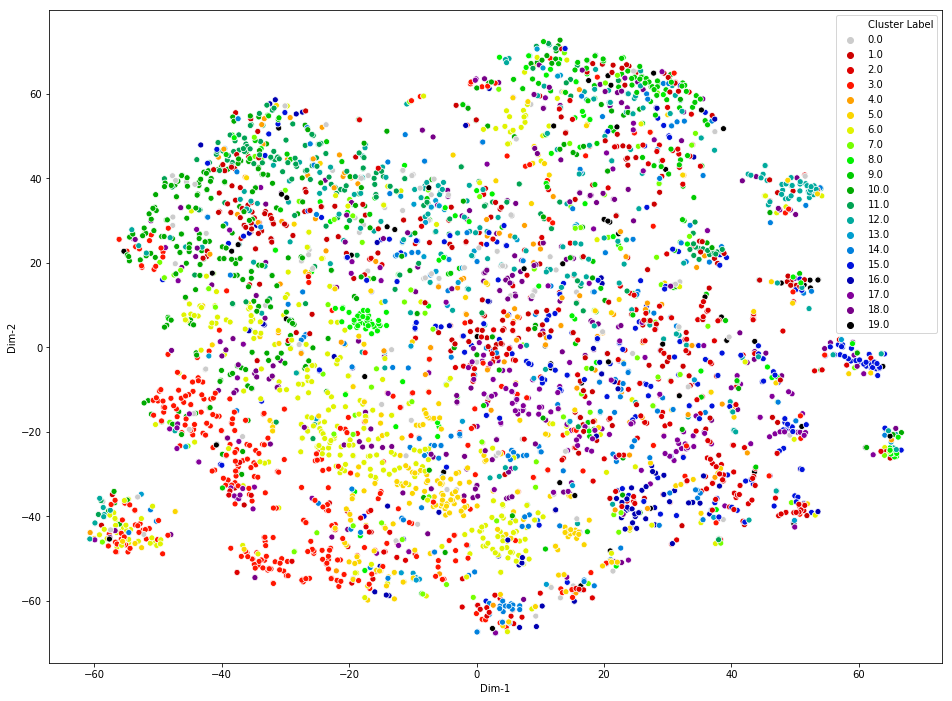

In [36]:
dfldamt = graph_cluster(tmatrix, dfmallet_merge)
dfldamt.to_csv('ldatmallet.csv')

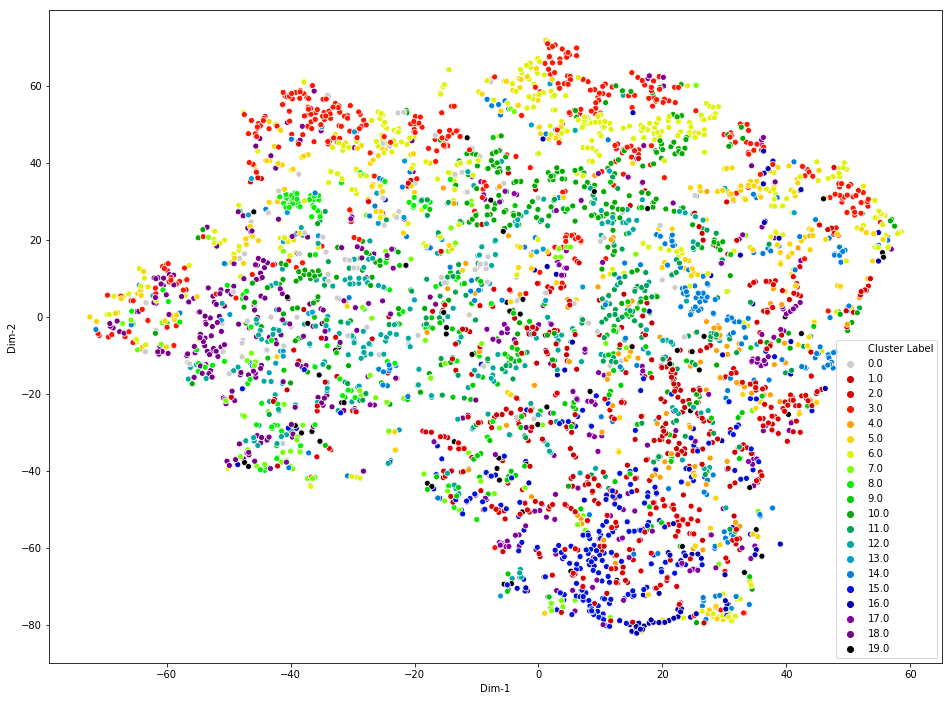

In [37]:
dfldamw = graph_cluster(wpt2v_array, dfmallet_merge)
dfldamw.to_csv('ldawmallet.csv')

In [131]:
#generate wordclouds for website
def wordcloud_get(df, label):
    text = df['Job Title'].values
    cv = CountVectorizer(min_df=.007, ngram_range=(2,3), tokenizer=gg_tokenize)
    cvm = cv.fit_transform(text)
    ftn = cv.get_feature_names()
    lab = df.index.tolist()
    crn = cvm.toarray()
    crnt = crn.transpose()
    topv = {}
    tot = len(df['Job Title'].values)
    for item,name in zip(crnt,cv.get_feature_names()):
        mn = item.sum()
        topv[name] = mn
    count = 0
    for key,value in topv.items():
        count+=value
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(topv)
    wordcloud.to_file(label)
    return count, tot

dflist = [dfkt, dfwt, dfw2g,dfldt, dfldamt]
label_list = ['tfkm', 'tfwh','w2vg','ldat','ldam']

for dft,st in zip(dflist, label_list):
    rnge = len(dft['Cluster Label'].unique())
    store = []
    for i in range(0,rnge):
        label = "C:\\Users\\Gary_Guo\\Documents\\GitHub\\autoapply\\static\\" + st + str(i) + '.png'
        count, tot = wordcloud_get(dft.loc[dft['Cluster Label']==i], label)
        row = [count, tot, count/tot]
        store.append(row)
    df = pd.DataFrame(data=store, columns=['Count', 'Postings in Cluster', 'Ratio'])
    df_name = 'C:\\Users\\Gary_Guo\\Documents\\GitHub\\autoapply\\data\\'+ st + 'wordcloud.csv'
    df.to_csv(df_name)

211
518
364
230
138
292
343
120
84
64
488
376
183
291
116
98
376
300
273
136
129
239
215
151
116
491
156
315
254
483
156
35
117
448
187
315
162
180
110
170
119
198
444
227
215
188
277
65
83
297
292
196
222
572
263
305
273
230
359
286
212
138
192
102
129
101
195
128
141
106
